In [ ]:
import pandas as pd
import numpy as np
import os
import time
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Modèles
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
os.makedirs('../output', exist_ok=True)

In [2]:
df = pd.read_csv("../data/clean/cleaned_data_filtered.csv")

In [3]:
df['room_bathroom_ratio'] = df['room_count'] / np.maximum(df['bathroom_count'], 1)
df['total_rooms'] = df['room_count'] + df['bathroom_count']
df['size_per_room'] = df['size'] / np.maximum(df['room_count'], 1)
df['bathroom_density'] = df['bathroom_count'] / np.maximum(df['size'], 1)
df['size_x_rooms'] = df['size'] * df['room_count']
df['size_x_bathrooms'] = df['size'] * df['bathroom_count']

# Locations premium et upscale
high_value_locations = ['tunis', 'ariana', 'ben arous', 'la manouba']
upscale_locations = ['nabeul', 'sousse', 'monastir', 'mahdia', 'bizerte']

# Encoding the features ( Binary flags to indicate luxuriousness of location)
df['is_premium_location'] = df['location'].str.lower().isin(high_value_locations).astype(int)
df['is_upscale_location'] = df['location'].str.lower().isin(upscale_locations).astype(int)


In [4]:
# Luxury score
df['luxury_score'] = (
        (df['size'] / 100) * 0.3 +
        (df['room_count'] / 5) * 0.2 +
        (df['bathroom_count'] / 2) * 0.2 +
        df['is_premium_location'] * 0.3 +
        df['is_upscale_location'] * 0.15
)

In [5]:
# Property tier
df['property_tier'] = pd.cut(df['luxury_score'],
                             bins=3,
                             labels=['standard', 'upscale', 'luxury'])

In [6]:
engineered_cols = ['room_bathroom_ratio', 'total_rooms', 'size_per_room',
                   'bathroom_density', 'size_x_rooms', 'size_x_bathrooms',
                   'luxury_score', 'is_premium_location', 'is_upscale_location']
for col in engineered_cols:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(df[col].median())

In [7]:
# Fonction pour ajouter les statistiques de location
def add_location_features(df_train, df_test, df_full):
    # Calculer sur train uniquement
    location_stats = df_train.groupby('location').agg({
        'price': ['median', 'mean', 'std', 'count']
    })
    location_stats.columns = ['location_price_median', 'location_price_mean', 
                              'location_price_std', 'location_count']
    location_stats = location_stats.reset_index()
    
    # Normaliser les stats de prix (pour éviter le leakage direct)
    location_stats['location_price_level'] = (
        location_stats['location_price_median'] / location_stats['location_price_median'].median()
    )
    
    # Merger sur train et test
    df_train_merged = df_train.merge(location_stats[['location', 'location_price_level']], 
                                     on='location', how='left')
    df_test_merged = df_test.merge(location_stats[['location', 'location_price_level']], 
                                   on='location', how='left')
    
    # Remplir les valeurs manquantes (nouvelles locations) avec la médiane
    global_median = location_stats['location_price_level'].median()
    df_train_merged['location_price_level'] = df_train_merged['location_price_level'].fillna(global_median)
    df_test_merged['location_price_level'] = df_test_merged['location_price_level'].fillna(global_median)
    
    return df_train_merged, df_test_merged, location_stats

categorical_cols = ['category', 'type', 'location', 'property_tier']

In [8]:
# Configuration des modèles avec leurs grilles
models_config = {
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'max_depth': [10, 15, 20, 25],
            'min_samples_split': [10, 20, 30],
            'min_samples_leaf': [5, 10, 15]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [15, 20, 25],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [2, 4, 6],
            'max_features': ['sqrt', 'log2']
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [4, 6, 8],
            'min_samples_split': [5, 10, 15],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2']
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'),
        "params": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [4, 6, 8],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    },
}

#### Optimisation des hyperparams

In [9]:
# Optimiser chaque modèle
optimized_models = {}
optimization_results = []

for name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"Optimisation: {name}")
    print(f"{'='*80}")
    
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"Nombre de combinaisons à tester: {n_combinations}")
    
    start_time = time.time()
    
    # Custom CV pour ajouter location_price_level sans leakage
    kf_opt = KFold(n_splits=3, shuffle=True, random_state=42)
    best_score = -np.inf
    best_params = None
    best_estimator = None
    
    # Grid Search manuel pour contrôler le preprocessing
    from sklearn.model_selection import ParameterGrid
    param_grid = list(ParameterGrid(config['params']))
    
    print(f"Testing {len(param_grid)} combinations...")
    
    for i, params in enumerate(param_grid):
        if i % 10 == 0:
            print(f"  Progress: {i}/{len(param_grid)}...", end='\r')
        
        scores = []
        for train_idx, test_idx in kf_opt.split(df):
            # Split data
            df_train_fold = df.iloc[train_idx].copy()
            df_test_fold = df.iloc[test_idx].copy()
            
            # Add location features (calculated on train only)
            df_train_fold, df_test_fold, _ = add_location_features(
                df_train_fold, df_test_fold, df
            )
            
            # One-hot encoding
            df_train_encoded = pd.get_dummies(df_train_fold, columns=categorical_cols, drop_first=False)
            df_test_encoded = pd.get_dummies(df_test_fold, columns=categorical_cols, drop_first=False)
            
            # Align columns
            missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
            for col in missing_cols:
                df_test_encoded[col] = 0
            df_test_encoded = df_test_encoded[df_train_encoded.columns]
            
            # Features and target
            feature_cols_fold = [col for col in df_train_encoded.columns 
                                if col not in ['price', 'log_price']]
            X_train_fold = df_train_encoded[feature_cols_fold]
            y_train_fold = df_train_encoded['log_price']
            X_test_fold = df_test_encoded[feature_cols_fold]
            y_test_fold = df_test_encoded['log_price']
            
            # Scale
            scaler_fold = StandardScaler()
            num_cols_fold = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
                            'total_rooms', 'size_per_room', 'bathroom_density',
                            'size_x_rooms', 'size_x_bathrooms', 'luxury_score',
                            'is_premium_location', 'location_price_level', 'is_upscale_location']
            num_cols_present = [col for col in num_cols_fold if col in X_train_fold.columns]
            X_train_fold[num_cols_present] = scaler_fold.fit_transform(X_train_fold[num_cols_present])
            X_test_fold[num_cols_present] = scaler_fold.transform(X_test_fold[num_cols_present])
            
            # Train and score
            model_fold = config['model'].__class__(**params, random_state=42)
            if hasattr(model_fold, 'n_jobs'):
                model_fold.n_jobs = -1
            model_fold.fit(X_train_fold, y_train_fold)
            score = model_fold.score(X_test_fold, y_test_fold)
            scores.append(score)
        
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
            best_estimator = config['model'].__class__(**params, random_state=42)
            if hasattr(best_estimator, 'n_jobs'):
                best_estimator.n_jobs = -1
    
    elapsed = time.time() - start_time
    
    print(f"\n\tTerminé en {elapsed:.1f}s")
    print(f"Meilleur score R²: {best_score:.4f}")
    print(f"Meilleurs paramètres:")
    for param, value in best_params.items():
        print(f"  * {param}: {value}")
    
    optimized_models[name] = best_estimator
    
    optimization_results.append({
        'Model': name,
        'Best_R2': best_score,
        'Best_Params': best_params,
        'Time_seconds': elapsed
    })


Optimisation: Decision Tree
Nombre de combinaisons à tester: 36
Testing 36 combinations...
  Progress: 30/36...
	Terminé en 3.7s
Meilleur score R²: 0.9626
Meilleurs paramètres:
  * max_depth: 10
  * min_samples_leaf: 15
  * min_samples_split: 10

Optimisation: Random Forest
Nombre de combinaisons à tester: 162
Testing 162 combinations...
  Progress: 160/162...
	Terminé en 123.0s
Meilleur score R²: 0.9635
Meilleurs paramètres:
  * max_depth: 20
  * max_features: sqrt
  * min_samples_leaf: 2
  * min_samples_split: 10
  * n_estimators: 100

Optimisation: Gradient Boosting
Nombre de combinaisons à tester: 486
Testing 486 combinations...
  Progress: 480/486...
	Terminé en 532.3s
Meilleur score R²: 0.9669
Meilleurs paramètres:
  * learning_rate: 0.05
  * max_depth: 4
  * max_features: sqrt
  * min_samples_split: 10
  * n_estimators: 200
  * subsample: 0.9

Optimisation: XGBoost
Nombre de combinaisons à tester: 729
Testing 729 combinations...
  Progress: 720/729...
	Terminé en 503.2s
Meilleu

#### Evaluation finale des modèles optimisés

In [10]:
# Calculer location_price_level sur l'ensemble complet (pour training final)
location_stats_full = df.groupby('location')['price'].median().reset_index()
location_stats_full['location_price_level'] = (
    location_stats_full['price'] / location_stats_full['price'].median()
)
df_final = df.merge(location_stats_full[['location', 'location_price_level']], 
                   on='location', how='left')
df_final['location_price_level'] = df_final['location_price_level'].fillna(1.0)

In [11]:
# One-hot encoding
df_encoded = pd.get_dummies(df_final, columns=categorical_cols, drop_first=False)

In [12]:
feature_cols = [col for col in df_encoded.columns if col not in ['price', 'log_price']]
X = df_encoded[feature_cols].copy()
y = df_encoded['log_price'].copy()

num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio', 
            'total_rooms', 'size_per_room', 'bathroom_density',
            'size_x_rooms', 'size_x_bathrooms', 'luxury_score',
            'is_premium_location', 'is_upscale_location' ,'location_price_level']

In [13]:
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print(f"Features finales: {X.shape[1]} colonnes")
print(f"Target: log10(price)")

Features finales: 45 colonnes
Target: log10(price)


In [14]:
# Évaluation avec 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_results = {}

for name, model in optimized_models.items():
    print(f"\nÉvaluation finale: {name}...")
    
    # Cross-validation scores
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    # Prédictions pour métriques détaillées
    y_pred_log = np.zeros_like(y)
    for train_idx, test_idx in kf.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred_log[test_idx] = model.predict(X.iloc[test_idx])
    
    # Métriques log-space
    rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
    mae_log = mean_absolute_error(y, y_pred_log)
    r2_log = r2_score(y, y_pred_log)
    
    # Back-transform avec bias correction
    y_actual = 10 ** y
    y_pred_raw = 10 ** y_pred_log
    
    df_temp = pd.DataFrame({
        'actual_log': y.values,
        'pred_log': y_pred_log,
        'type': df['type'].values
    })
    
    bias_factors = {}
    for prop_type in df_temp['type'].unique():
        mask = df_temp['type'] == prop_type
        mean_actual = np.mean(df_temp.loc[mask, 'actual_log'])
        mean_pred = np.mean(df_temp.loc[mask, 'pred_log'])
        bias_factors[prop_type] = 10 ** (mean_actual - mean_pred)
    
    y_pred_corrected = np.array([
        y_pred_raw[i] * bias_factors[df['type'].iloc[i]] 
        for i in range(len(y_pred_raw))
    ])
    
    # Métriques espace réel
    rmse_actual = np.sqrt(mean_squared_error(y_actual, y_pred_corrected))
    mae_actual = mean_absolute_error(y_actual, y_pred_corrected)
    mape = np.mean(np.abs((y_actual - y_pred_corrected) / y_actual) * 100)
    
    final_results[name] = {
        'R2_log': r2_log,
        'R2_std': r2_scores.std(),
        'RMSE_log': rmse_log,
        'MAE_log': mae_log,
        'RMSE_actual': rmse_actual,
        'MAE_actual': mae_actual,
        'MAPE': mape
    }


Évaluation finale: Decision Tree...

Évaluation finale: Random Forest...

Évaluation finale: Gradient Boosting...

Évaluation finale: XGBoost...


In [15]:
# Créer tableau récapitulatif
results_df = pd.DataFrame(final_results).T
results_df = results_df.sort_values('R2_log', ascending=False)

print("\n" + "=" * 100)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES FINALES")
print("=" * 100)
print("\n", results_df.round(4).to_string())

# Identifier le meilleur
best_model_name = results_df['R2_log'].idxmax()
best_model = optimized_models[best_model_name]

print("\n" + "=" * 100)
print(f"\nLe meilleur modèle est: {best_model_name}")
print(f"  • R² = {results_df.loc[best_model_name, 'R2_log']:.4f}")
print(f"  • MAE = {results_df.loc[best_model_name, 'MAE_actual']:,.0f} TND")
print(f"  • MAPE = {results_df.loc[best_model_name, 'MAPE']:.2f}%")


TABLEAU RÉCAPITULATIF DES PERFORMANCES FINALES

                    R2_log  R2_std  RMSE_log  MAE_log  RMSE_actual  MAE_actual     MAPE
XGBoost            0.9677  0.0016    0.2248   0.1558  168524.6141  70240.3186  50.5696
Gradient Boosting  0.9668  0.0019    0.2279   0.1576  171211.2372  70515.3644  50.8193
Random Forest      0.9634  0.0016    0.2393   0.1681  172365.9028  72004.0478  52.8963
Decision Tree      0.9632  0.0009    0.2399   0.1704  172731.1172  73969.6803  54.5144


Le meilleur modèle est: XGBoost
  • R² = 0.9677
  • MAE = 70,240 TND
  • MAPE = 50.57%


In [16]:
# Entraîner le modèle final sur toutes les données
print("\nEntraînement du modèle final sur toutes les données...")
best_model.fit(X, y)


Entraînement du modèle final sur toutes les données...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


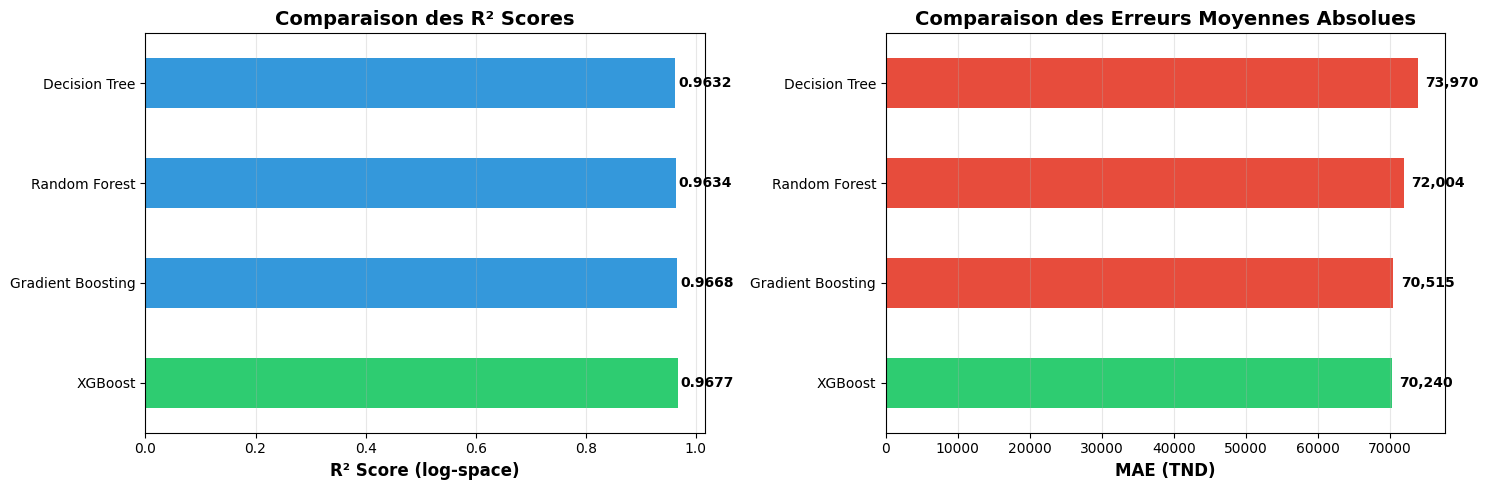

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# R² scores
ax1 = axes[0]
colors = ['#2ecc71' if x == results_df['R2_log'].max() else '#3498db'
          for x in results_df['R2_log']]
results_df['R2_log'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('R² Score (log-space)', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison des R² Scores', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['R2_log']):
    ax1.text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# MAE
ax2 = axes[1]
colors = ['#2ecc71' if x == results_df['MAE_actual'].min() else '#e74c3c'
          for x in results_df['MAE_actual']]
results_df['MAE_actual'].plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('MAE (TND)', fontsize=12, fontweight='bold')
ax2.set_title('Comparaison des Erreurs Moyennes Absolues', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['MAE_actual']):
    ax2.text(v + 1000, i, f'{v:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

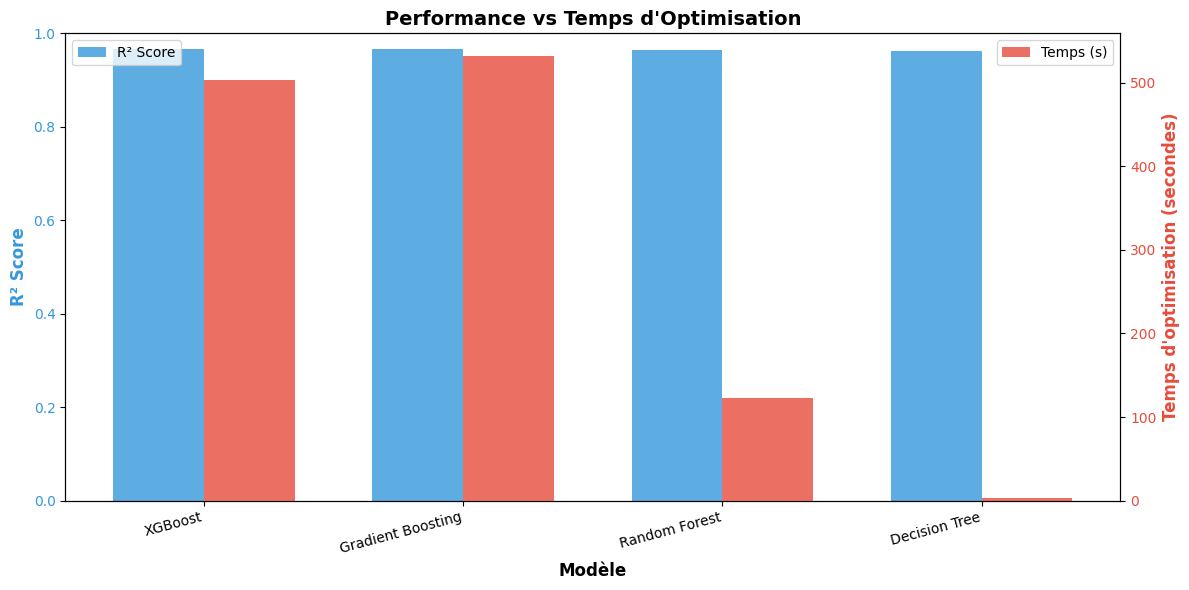

In [19]:
opt_df = pd.DataFrame(optimization_results)
opt_df = opt_df.sort_values('Best_R2', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(opt_df))
width = 0.35

ax1 = ax
bars1 = ax1.bar(x - width/2, opt_df['Best_R2'], width, label='R² Score', color='#3498db', alpha=0.8)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold', color='#3498db')
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.set_ylim([0, 1])

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, opt_df['Time_seconds'], width, label='Temps (s)', color='#e74c3c', alpha=0.8)
ax2.set_ylabel('Temps d\'optimisation (secondes)', fontsize=12, fontweight='bold', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

ax1.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax1.set_title('Performance vs Temps d\'Optimisation', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(opt_df['Model'], rotation=15, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

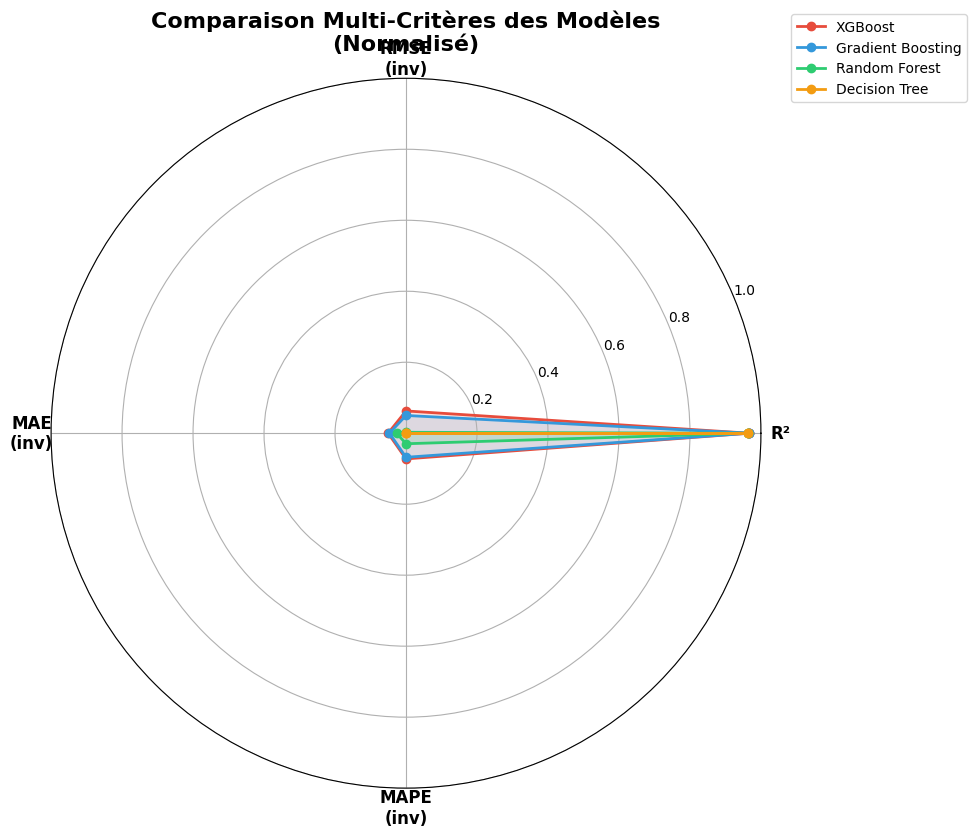

In [21]:
from math import pi

# Normaliser les métriques pour le radar chart
metrics_normalized = results_df.copy()
metrics_normalized['R2_log'] = results_df['R2_log']
metrics_normalized['RMSE_inv'] = 1 - (results_df['RMSE_log'] / results_df['RMSE_log'].max())
metrics_normalized['MAE_inv'] = 1 - (results_df['MAE_actual'] / results_df['MAE_actual'].max())
metrics_normalized['MAPE_inv'] = 1 - (results_df['MAPE'] / results_df['MAPE'].max())

categories = ['R²', 'RMSE\n(inv)', 'MAE\n(inv)', 'MAPE\n(inv)']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for idx, (model_name, row) in enumerate(metrics_normalized.iterrows()):
    values = [row['R2_log'], row['RMSE_inv'], row['MAE_inv'], row['MAPE_inv']]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True)
ax.set_title('Comparaison Multi-Critères des Modèles\n(Normalisé)',
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()